In [94]:
%matplotlib inline

# Cluster Analysis 

This notebook prototypes the cluster analysis visualizers that I'm currently putting together.

**NOTE**: Currently I'm using the sklearn `make_blobs` function to create test datasets with specific numbers of clusters. However, in order to add this to the documentation, we should add a real dataset. 

In [14]:
import sys 
sys.path.append("../..")

import numpy as np
import yellowbrick as yb 
import matplotlib.pyplot as plt 

from functools import partial
from sklearn.datasets import make_blobs as sk_make_blobs
from sklearn.datasets import make_circles, make_moons

In [3]:
# Helpers for easy dataset creation 
N_SAMPLES = 1000 
N_FEATURES = 12 
SHUFFLE = True 

# Make blobs partial 
make_blobs = partial(sk_make_blobs, n_samples=N_SAMPLES, n_features=N_FEATURES, shuffle=SHUFFLE)

## Elbow Method 

This method runs multiple clustering instances and computes the average silhoutte score for each K. Model selection works by selecting the K that is the "elbow" of a curve that looks like an arm. 

In [4]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

### 8 Blobs Dataset 

This series shows the use of different metrics with a dataset that does contain centers

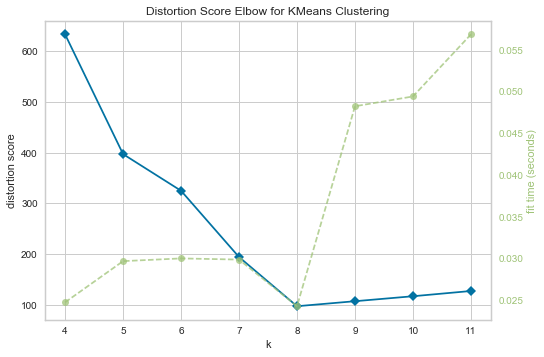

In [7]:
## Make 8 blobs dataset 
X, y = make_blobs(centers=8)
visualizer = KElbowVisualizer(KMeans(), k=(4,12))
visualizer.fit(X)
visualizer.poof()

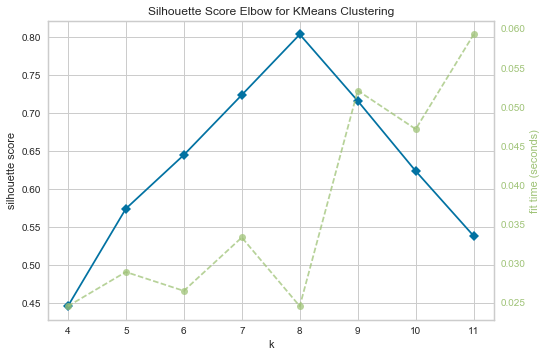

In [10]:
visualizer = KElbowVisualizer(KMeans(), k=(4,12), metric="silhouette")
visualizer.fit(X)
visualizer.poof()

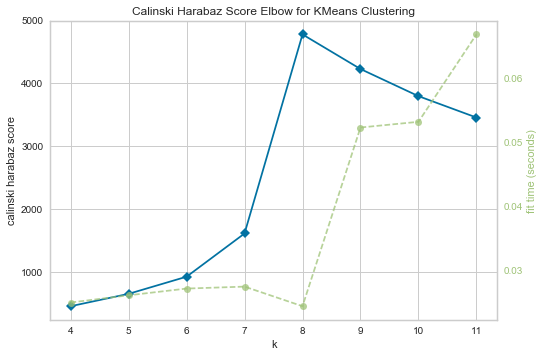

In [11]:
visualizer = KElbowVisualizer(KMeans(), k=(4,12), metric="calinski_harabaz")
visualizer.fit(X)
visualizer.poof()

### Datasets without Centers

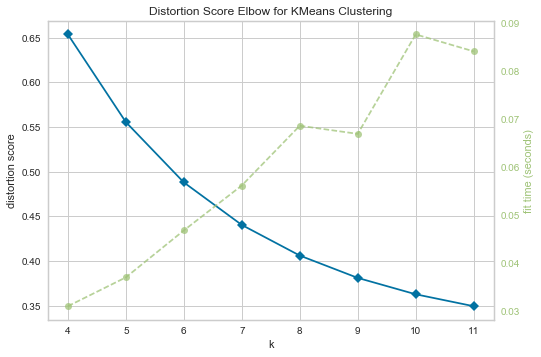

In [12]:
## Make cicles dataset 
X, y = make_circles(n_samples=N_SAMPLES)
visualizer = KElbowVisualizer(KMeans(), k=(4,12))
visualizer.fit(X)
visualizer.poof()

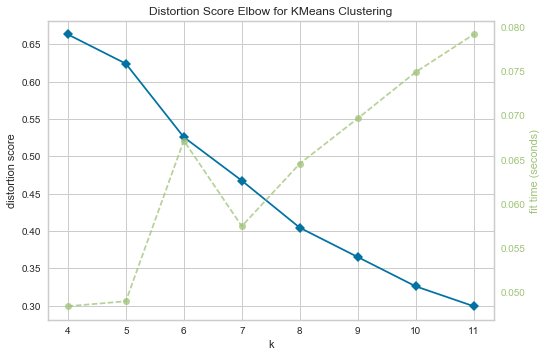

In [13]:
## Make moons dataset 
X, y = make_moons(n_samples=N_SAMPLES)
visualizer = KElbowVisualizer(KMeans(), k=(4,12))
visualizer.fit(X)
visualizer.poof()

## Silhouette Score 

Visualizer using the silhouette score metric 

In [14]:
from yellowbrick.cluster import SilhouetteVisualizer

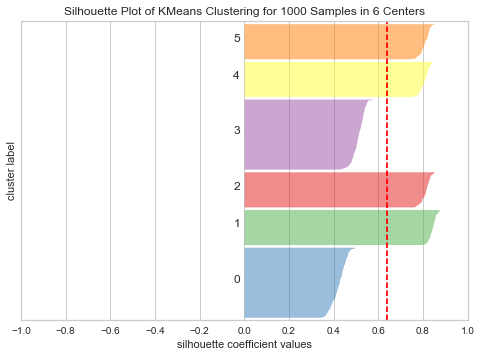

In [15]:
## Make 8 blobs dataset 
X, y = make_blobs(centers=8)
visualizer = SilhouetteVisualizer(KMeans(6))
visualizer.fit(X)
visualizer.poof()

## Intercluster Distance Map

In [171]:
def prop_to_size(prop, mi=0, ma=5, power=0.5):
    """
    Scale a property to be used as a size 
    """
    prop = np.asarray(prop)

    return mi + (ma - mi)*(((prop - prop.min()) / (prop.max() - prop.min()))**power)

In [181]:
from sklearn.manifold import MDS 

## Make 12 blobs dataset 
X, y = make_blobs(centers=12)

## Fit KMeans model on dataset 
model = KMeans(9).fit(X)

[25000.           400.           400.          3084.0800499
  3084.0800499  24853.13301574 25000.           400.
   400.        ] [89.20620581 11.28379167 11.28379167 31.33198317 31.33198317 88.94379091
 89.20620581 11.28379167 11.28379167]


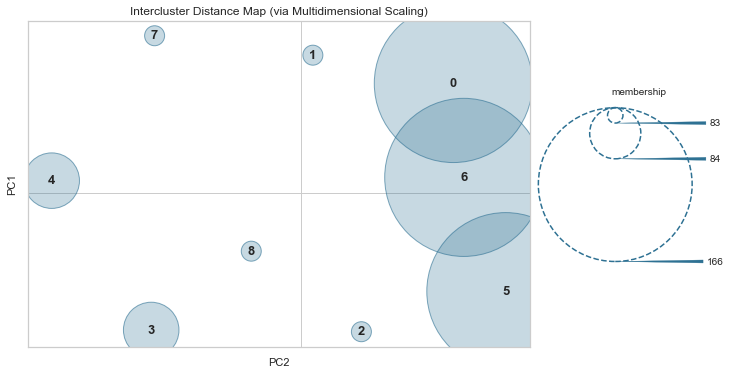

In [317]:
from matplotlib.lines import Line2D

def intercluster_distance(model, ax=None):
    # Create the figure if an axes isn't passed in 
    if ax is None:
        fig, ax = plt.subplots(figsize=(9,6))
    else:
        fig = plt.gcf()
    
    ## Get centers 
    ## TODO: is this how sklearn stores centers in all models? 
    C = model.cluster_centers_

    ## Compute the sizes of the clusters 
    scores = np.bincount(model.predict(X))
    size = prop_to_size(scores, 400, 25000)

    ## Use MDS to plot centers 
    Cm = MDS().fit_transform(C)
    ax.scatter(Cm[:,0], Cm[:,1], s=size, c='#2e719344', edgecolor='#2e719399', linewidth=1)

    ## Annotate the clustes with their labels 
    for i, pt in enumerate(Cm):
        ax.text(s=str(i), x=pt[0], y=pt[1], va="center", ha="center", fontweight='bold', size=13)
    
    ## Set the title 
    ax.set_title("Intercluster Distance Map (via Multidimensional Scaling)")
    
    # Create origin grid 
    ax.set_xticks([0])
    ax.set_yticks([0])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("PC2")
    ax.set_ylabel("PC1")
    
    # Create a regular legend with target "size" descriptor 
#     handles = tuple([
#         Line2D([0], [0], color="none", marker="o", markersize=i, markerfacecolor='none', markeredgecolor="#999999", markeredgewidth=1, markevery=i)
#         for i in [3,9,18]
#     ])
#     ax.legend([handles], ['membership',], loc='best')

    # Create the size legend on an inner axes 
    lax = fig.add_axes([.9, 0.25, 0.3333, 0.5], frameon=False, facecolor="none")
    make_size_legend(scores, size, lax)
        
    return ax 

intercluster_distance(model)

In [307]:
from matplotlib.patches import Circle 

def make_size_legend(scores, areas, ax=None):
    # Create the figure if an axes isn't passed in 
    if ax is None:
        _, ax = plt.subplots()

    ## Compute the sizes of the clusters 
    radii = np.sqrt(areas / np.pi)
    scaled = np.interp(radii, (radii.min(), radii.max()), (.1, 1))
    print(size, radii)
    
    # Compute the locations of the 25th, 50th, and 75th percentiles of the score 
    indices = np.array([
        np.where(scores==np.percentile(scores, p, interpolation='nearest'))[0][0]
        for p in (25, 50, 75)
    ])
    
    # Draw circles with their various sizes 
    for idx in indices:
        center = (-0.30, 1-scaled[idx])
        c = Circle(center, scaled[idx], facecolor="none", edgecolor="#2e7193", linewidth=1.5, linestyle="--", label="bob")
        ax.add_patch(c)
        
        ax.annotate(
            scores[idx], (-0.30, 1-(2*scaled[idx])), xytext=(1, 1-(2*scaled[idx])), 
            arrowprops=dict(arrowstyle="wedge", color="#2e7193"), va='center', ha='center',
        )
    
    # Draw size legend title 
    ax.text(s="membership", x=0, y=1.2, va='center', ha='center')
    
    ax.set_xlim(-1.4,1.4)
    ax.set_ylim(-1.4,1.4)
    ax.set_xticks([])
    ax.set_yticks([])
    for name in ax.spines:
        ax.spines[name].set_visible(False)
    
    ax.grid(False)
    
    return ax 